Importing Libraries

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, 
                                      ReduceLROnPlateau, TensorBoard)

Processing the datasets (Including dataset splitting)

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

def prepare_dataset(dataset_dir="datasets", test_size=0.2, val_size=0.2):
  
    splits = ['train', 'val', 'test']
    classes = ['valid', 'invalid']
    
    for split in splits:
        for cls in classes:
            os.makedirs(os.path.join(dataset_dir, split, cls), exist_ok=True)
    
    class_counts = {'valid': 0, 'invalid': 0}
    
    for cls in classes:
        src_dir = os.path.join(dataset_dir, cls)
        files = [f for f in os.listdir(src_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        files = [os.path.join(src_dir, f) for f in files]
        class_counts[cls] = len(files)
        
        train_val_files, test_files = train_test_split(files, test_size=test_size, random_state=42)
        
        train_files, val_files = train_test_split(train_val_files, test_size=val_size, random_state=42)
        
        for f in train_files:
            shutil.copy(f, os.path.join(dataset_dir, 'train', cls))
        for f in val_files:
            shutil.copy(f, os.path.join(dataset_dir, 'val', cls))
        for f in test_files:
            shutil.copy(f, os.path.join(dataset_dir, 'test', cls))
    
    total_samples = sum(class_counts.values())
    class_weights = {
        0: total_samples / (2 * class_counts['invalid']),  
        1: total_samples / (2 * class_counts['valid'])     
    }
    
    print("Dataset prepared successfully!")
    print(f"Train: {len(train_files)} valid, {len(train_files)} invalid images")
    print(f"Val: {len(val_files)} valid, {len(val_files)} invalid images")
    print(f"Test: {len(test_files)} valid, {len(test_files)} invalid images")
    print(f"Class weights: {class_weights}")
    
    return class_weights


In [3]:
CLASS_WEIGHTS = prepare_dataset()
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

Dataset prepared successfully!
Train: 152 valid, 152 invalid images
Val: 39 valid, 39 invalid images
Test: 48 valid, 48 invalid images
Class weights: {0: 0.8368200836820083, 1: 1.2422360248447204}


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    color_mode='rgb'
)

val_generator = val_test_datagen.flow_from_directory(
    'dataset/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    color_mode='rgb'
)

test_generator = val_test_datagen.flow_from_directory(
    'dataset/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    color_mode='rgb'
)


Found 339 images belonging to 2 classes.
Found 85 images belonging to 2 classes.
Found 106 images belonging to 2 classes.


In [7]:
def create_advanced_cnn(input_shape=(224, 224, 3)):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(0.1)(x)
    x = layers.RandomZoom(0.1)(x)
    x = layers.RandomContrast(0.1)(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    optimizer = optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    )
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    
    return model

model = create_advanced_cnn()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │   102,760,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 103,023,681 (393.00 MB)

 Trainable params: 103,022,401 (393.00 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [8]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        verbose=1,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        'best_strike_model.keras',
        monitor='val_auc',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    TensorBoard(
        log_dir='./logs',
        histogram_freq=1,
        update_freq='epoch'
    )
]

EPOCHS = 20

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=CLASS_WEIGHTS,
    verbose=1
)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.5507 - auc: 0.5456 - loss: 1.8027 - precision: 0.4002 - recall: 0.6119 
Epoch 1: val_auc improved from -inf to 0.56840, saving model to best_strike_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 292s 26s/step - accuracy: 0.5522 - auc: 0.5482 - loss: 1.7921 - precision: 0.4043 - recall: 0.6123 - val_accuracy: 0.3765 - val_auc: 0.5684 - val_loss: 1.5555 - val_precision: 0.3765 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.6465 - auc: 0.7054 - loss: 1.3522 - precision: 0.5151 - recall: 0.7104 
Epoch 2: val_auc improved from 0.56840 to 0.72406, saving model to best_strike_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 275s 23s/step - accuracy: 0.6462 - auc: 0.7044 - loss: 1.3505 - precision: 0.5155 - recall: 0.7104 - val_accuracy: 0.3765 - val_auc: 0.7241 - val_loss: 2.0376 - val_precision: 0.3765 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/20
11/11 ━━━━━━━━━━━━━━

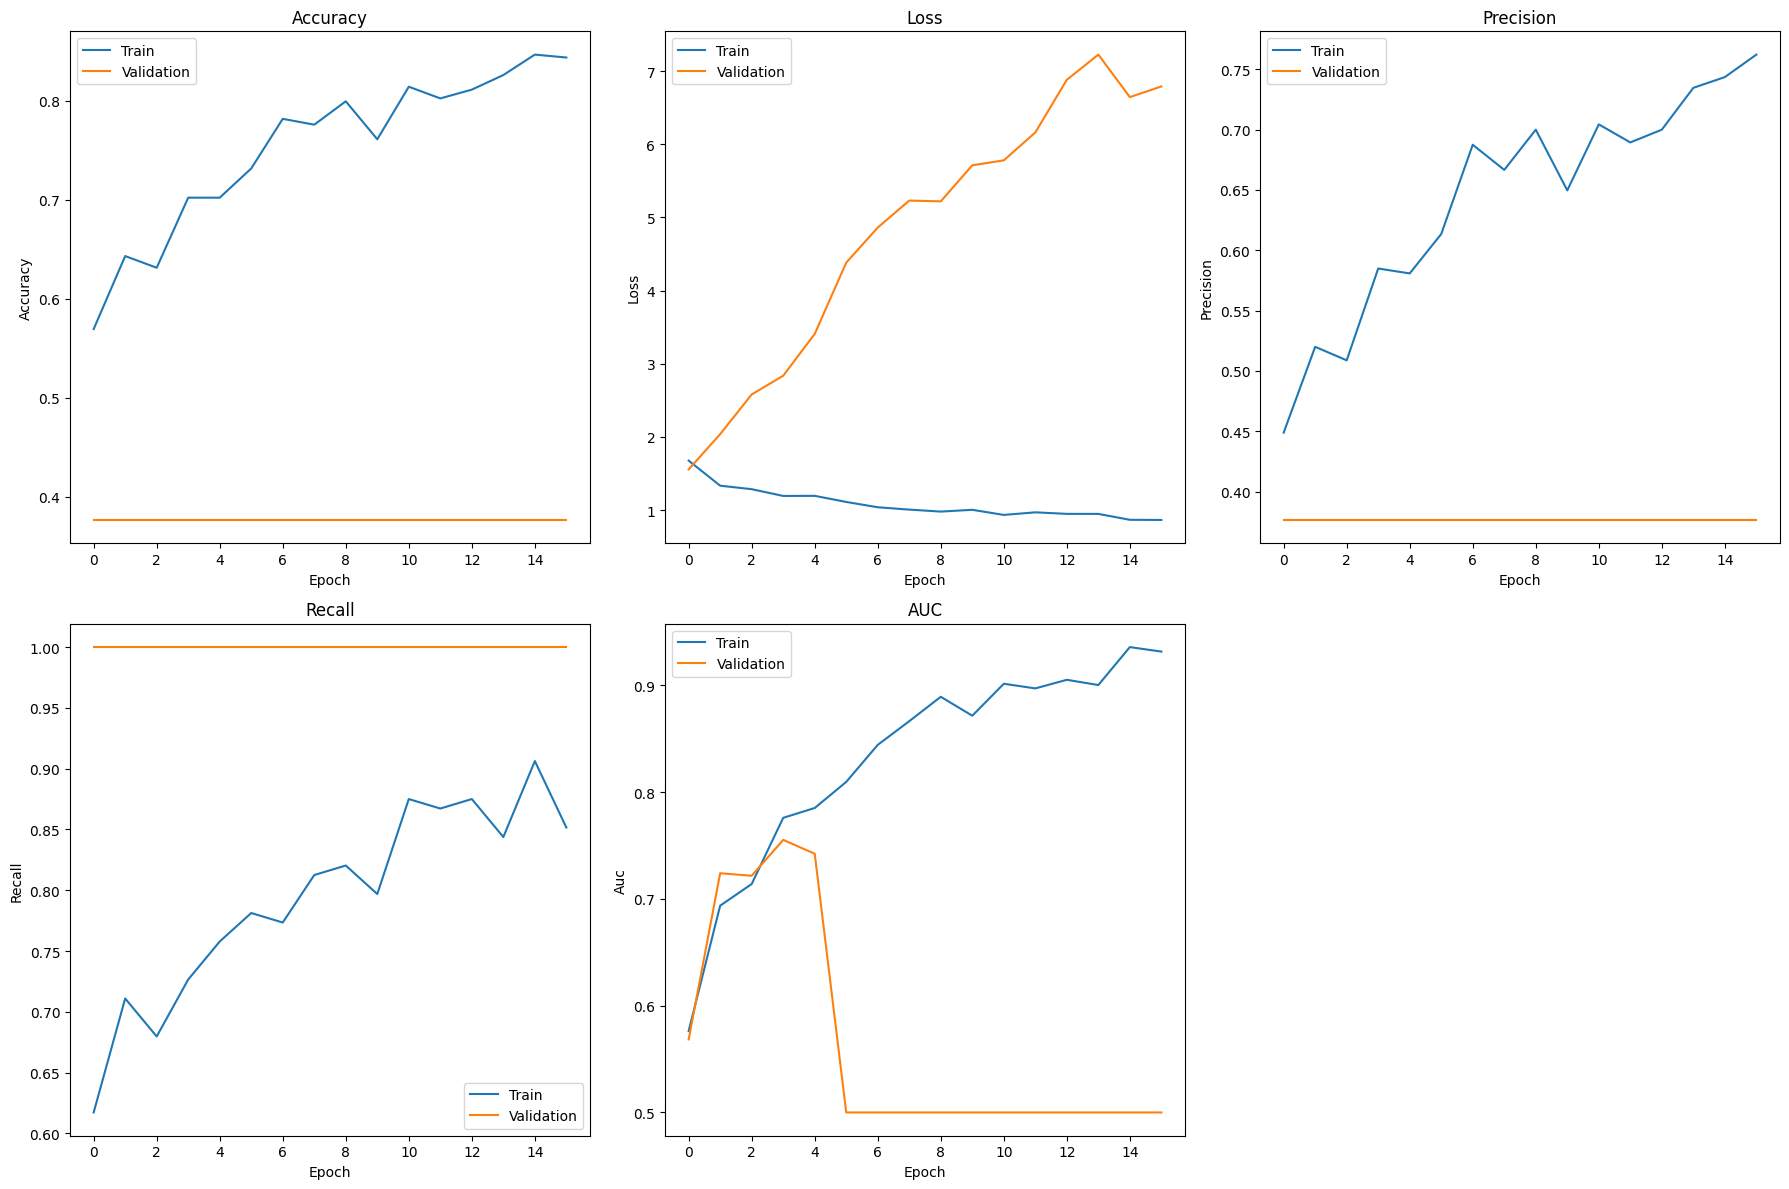


Evaluating on test set...
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.2134 - auc: 0.3257 - loss: 1.7609 - precision: 0.2134 - recall: 0.6000           

Test Results:
Loss: 1.5559
Accuracy: 0.3774
Precision: 0.3774
Recall: 1.0000
AUC: 0.5193


In [9]:
def plot_training_history(history):
    plt.figure(figsize=(18, 12))
    
    metrics = ['accuracy', 'loss', 'precision', 'recall', 'auc']
    titles = ['Accuracy', 'Loss', 'Precision', 'Recall', 'AUC']
    
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        plt.plot(history.history[metric], label='Train')
        if f'val_{metric}' in history.history:
            plt.plot(history.history[f'val_{metric}'], label='Validation')
        plt.title(titles[i])
        plt.ylabel(metric.capitalize())
        plt.xlabel('Epoch')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

print("\nEvaluating on test set...")
test_results = model.evaluate(test_generator, verbose=1)
print(f"\nTest Results:")
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.4f}")
print(f"Precision: {test_results[2]:.4f}")
print(f"Recall: {test_results[3]:.4f}")
print(f"AUC: {test_results[4]:.4f}")


Found 81 images belonging to 2 classes.


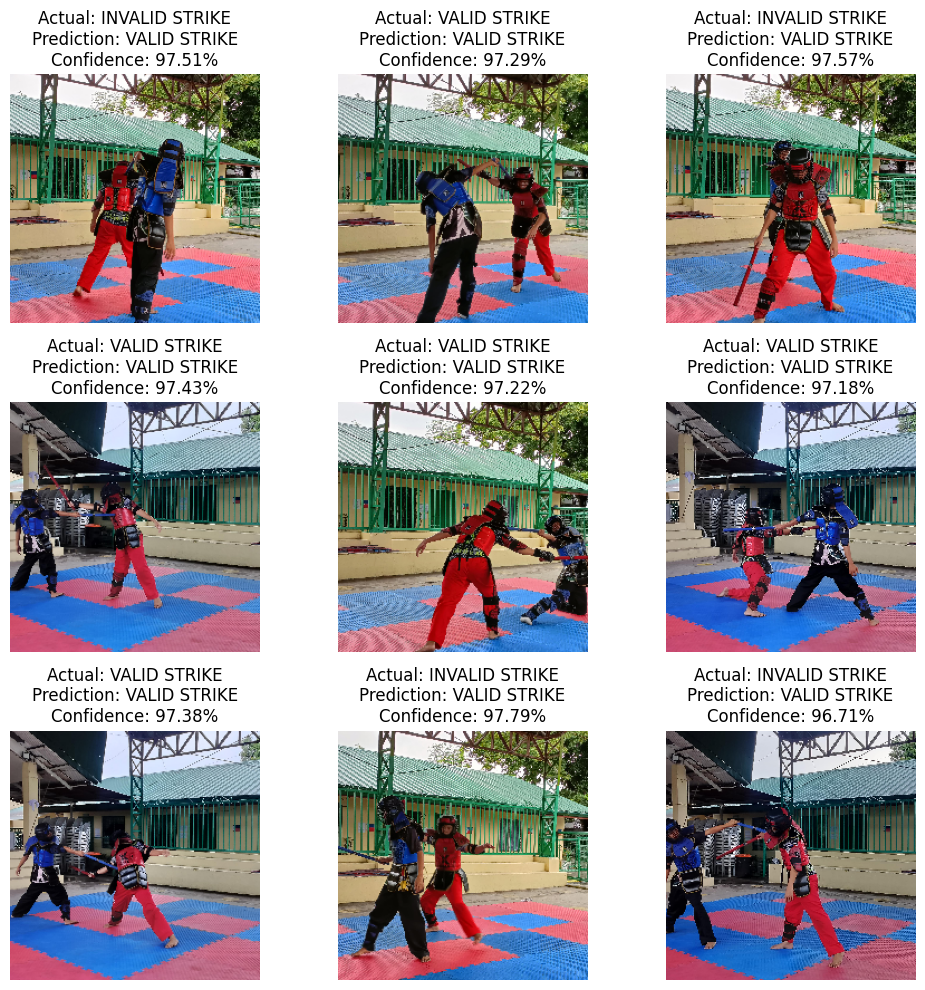

In [ ]:
def classify_test_images(test_dir="datasets/test", num_samples=9):
    model = load_model('best_strike_model.keras')  
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224,224),
        batch_size=1,
        class_mode='binary',
        shuffle=True
    )
    
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        img, true_label = next(test_generator)
        
        pred = model.predict(img, verbose=0)[0][0]
        confidence = max(pred, 1 - pred)
        predicted_label = "VALID STRIKE" if pred > 0.3 else "INVALID STRIKE"
        actual_label = "VALID STRIKE" if true_label[0] else "INVALID STRIKE"
        
        plt.subplot(3, 3, i+1)
        plt.imshow(img[0])
        plt.title(f"Actual: {actual_label}\n"
                 f"Prediction: {predicted_label}\n"
                 f"Confidence: {confidence:.2%}",
                 )
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

classify_test_images()


In [16]:

def classify_single_image(img_path):
    model = load_model('output/models/CNN_v2.h5')  

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  

    prediction = model.predict(img_array)
    confidence = prediction[0][0]
    label = "VALID STRIKE" if confidence > 0.3 else "INVALID STRIKE"
    confidence = max(confidence, 1 - confidence) 

    plt.figure(figsize=(8, 8))
    plt.imshow(image.load_img(img_path))
    plt.title(f"{label}\nConfidence: {confidence:.2%}", 
              color='green' if label == "VALID STRIKE" else 'red')
    plt.axis('off')
    plt.show()

    return label, confidence

image_path = "dataset/test/invalid/IMG20250705161729.jpg"
label, confidence = classify_single_image(image_path, model)
print(f"\nResult: {label} ({confidence:.2%} confidence)")

TypeError: classify_single_image() takes 1 positional argument but 2 were given